# Applying Neural Networks to MNIST Dataset and Fashion MNIST dataset

Most machine learning workflows involve working with data, creating models, optimizing model parameters, and saving the trained models. This tutorial introduces you to a complete ML workflow implemented in PyTorch covering all these steps.

#Applying Neural Network to MNIST dataset

**Importing libraries**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random
import numpy as np

Check if GPU is available.

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print ('<== CUDA availability : ==>', use_cuda)

<== CUDA availability : ==> True


**Set seed for reproducability.**

In [ ]:
def set_seeds(seed):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.determinictic = True
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
set_seeds(42)

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio, all of which include datasets. For this lab, we will be using a TorchVision dataset. Load one of the prebuilt datasets from pytorch repository. Currently, we are not using any transform (manipulation) on input data. We are just converting each image to tensor.


In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 106937539.37it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 118296576.00it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29448999.53it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9953254.32it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



**Visualising some of the input images.**

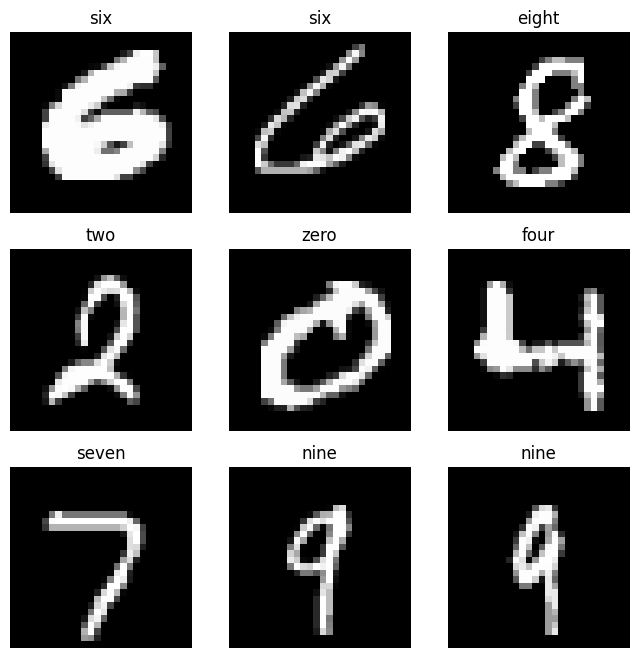

In [ ]:
labels_map = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()  # randomly pick indices from the training data
    img, label = training_data[sample_idx]                            # Read the images using their indices.
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Check the size and shape of training and validation data.

In [ ]:
print ('Shape of Training Data', np.shape(training_data))
print ('Shape of Test Data', np.shape(test_data))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Shape of Training Data (60000, 2)
Shape of Test Data (10000, 2)


The shape of the training set is (6000,2). This means that we have 6000 thousand samples with 2 entities. The first entity is the image and the second entity is its label. Forexample:

**training_data[0][0]** is the first image of training set

**training_data[0][1]** is the label of the first image in the training set

Now pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


**Define the loss function and set up optimiser.**

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3 )

**Define train function.**

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

**Define evaluation function.**

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

**Initiate Training Process**

Epoch 1
-------------------------------
test loss: 
Accuracy: 23.4%, avg loss: 2.277006 

Epoch 2
-------------------------------
test loss: 
Accuracy: 43.4%, avg loss: 2.238353 

Epoch 3
-------------------------------
test loss: 
Accuracy: 60.9%, avg loss: 2.175058 

Epoch 4
-------------------------------
test loss: 
Accuracy: 66.1%, avg loss: 2.066408 

Epoch 5
-------------------------------
test loss: 
Accuracy: 69.9%, avg loss: 1.889621 

Done!


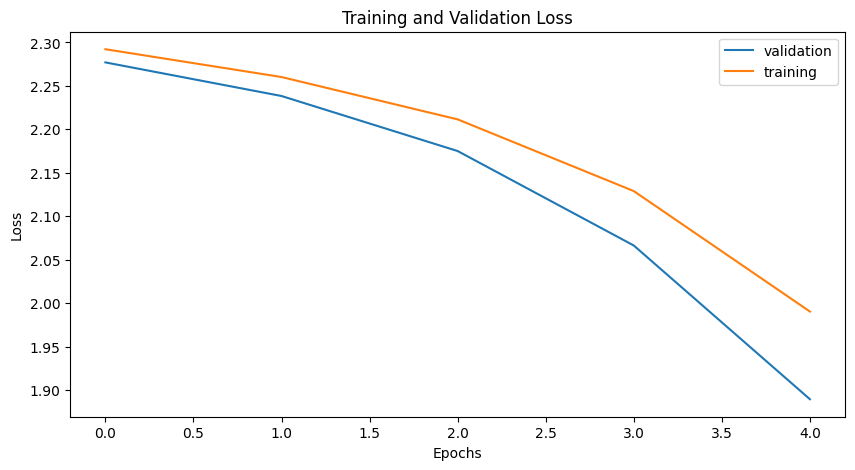

In [ ]:
epochs = 5
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Try 5, 10 and 50 epoch and record values for average validation loss and accuracy

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Perform Inferrence

Predicted: "six", Actual: "four"


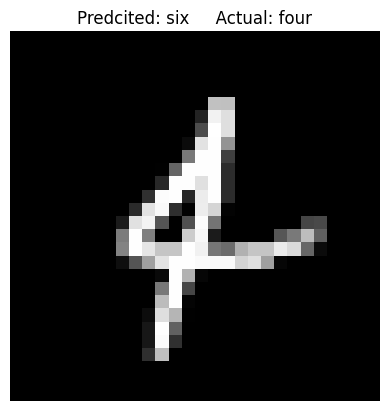

In [ ]:
classes = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
]
#classes = np.array(test_data.class_to_idx.values())
#testimg = random.
model.eval()
sample_number = 300 # Keep 0 <= sample_number < 10,000
x, y = test_data[sample_number][0], test_data[sample_number][1]
model.to("cpu")
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

img, label = test_data[sample_number]                            # Read the images using their indices.
    #figure.add_subplot(rows, cols, i)
plt.figure()
plt.title("Predcited: "+ predicted + "     Actual: " + labels_map[label])
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")

### Trying different combinations of optimizer function, epochs and layers of neural network to obtain the best accuracy.

###Combination 1 (Increasing Epochs to 10):
* Optimizer Function: Adam
* Epochs: 10
* Width of each Layer: 128
* Depth of network: 3
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 97.9%, avg loss: 0.190850 

Epoch 2
-------------------------------
test loss: 
Accuracy: 98.1%, avg loss: 0.174457 

Epoch 3
-------------------------------
test loss: 
Accuracy: 98.1%, avg loss: 0.183076 

Epoch 4
-------------------------------
test loss: 
Accuracy: 98.0%, avg loss: 0.183444 

Epoch 5
-------------------------------
test loss: 
Accuracy: 98.0%, avg loss: 0.183275 

Epoch 6
-------------------------------
test loss: 
Accuracy: 98.0%, avg loss: 0.180876 

Epoch 7
-------------------------------
test loss: 
Accuracy: 97.8%, avg loss: 0.208211 

Epoch 8
-------------------------------
test loss: 
Accuracy: 98.0%, avg loss: 0.177817 

Epoch 9
-------------------------------
test loss: 
Accuracy: 98.0%, avg loss: 0.201241 

Epoch 10
-------------------------------
test loss: 
Accuracy: 98.0%, avg loss: 0.217395 

Done!


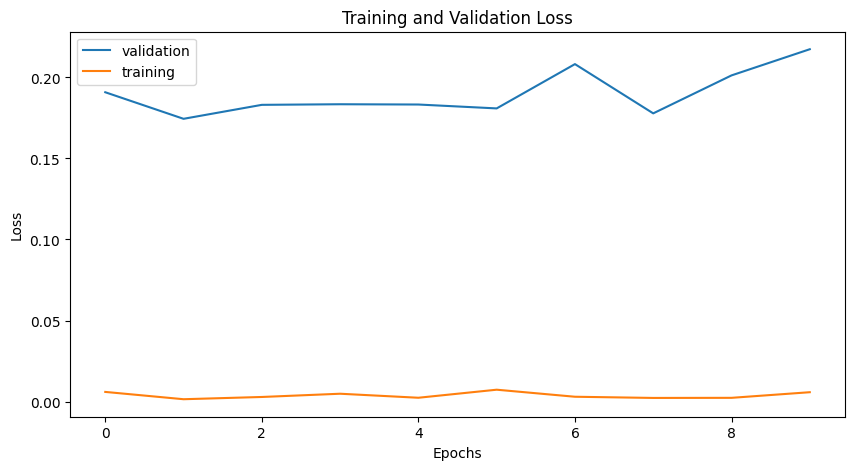

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 2 (Increasing Epochs to 50):
* Optimizer Function: Adam
* Epochs: 50
* Width of each Layer: 128
* Depth of network: 3
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 97.5%, avg loss: 0.102422 

Epoch 2
-------------------------------
test loss: 
Accuracy: 97.7%, avg loss: 0.098786 

Epoch 3
-------------------------------
test loss: 
Accuracy: 97.8%, avg loss: 0.097156 

Epoch 4
-------------------------------
test loss: 
Accuracy: 97.7%, avg loss: 0.114724 

Epoch 5
-------------------------------
test loss: 
Accuracy: 97.8%, avg loss: 0.102930 

Epoch 6
-------------------------------
test loss: 
Accuracy: 97.6%, avg loss: 0.125575 

Epoch 7
-------------------------------
test loss: 
Accuracy: 97.6%, avg loss: 0.119214 

Epoch 8
-------------------------------
test loss: 
Accuracy: 97.4%, avg loss: 0.143292 

Epoch 9
-------------------------------
test loss: 
Accuracy: 97.6%, avg loss: 0.119849 

Epoch 10
-------------------------------
test loss: 
Accuracy: 97.3%, avg loss: 0.135874 

Epoch 11
-------------------------------
test loss: 
Accuracy: 97.8%, avg loss: 0.120236 

Epoch 12

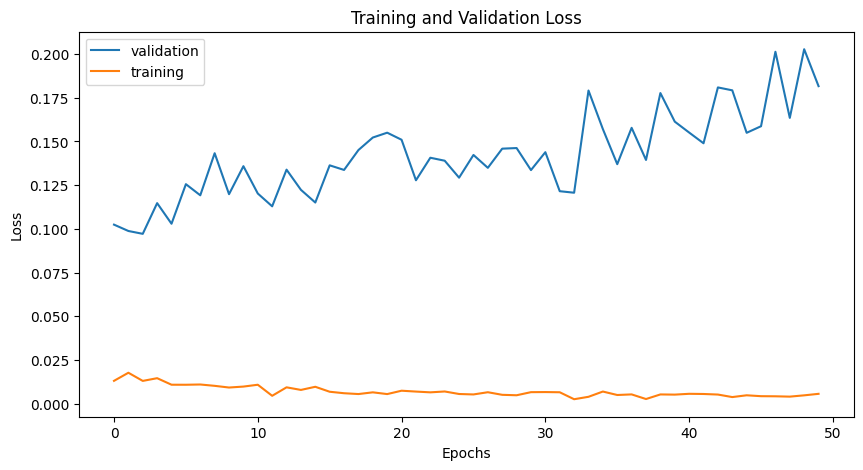

In [ ]:
epochs = 50
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 3 (Changing width and depth):
* Optimizer Function: Adam
* Epochs: 10
* Width of each Layer: 256
* Depth of network: 4
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 95.2%, avg loss: 0.156212 

Epoch 2
-------------------------------
test loss: 
Accuracy: 97.0%, avg loss: 0.106083 

Epoch 3
-------------------------------
test loss: 
Accuracy: 97.0%, avg loss: 0.104382 

Epoch 4
-------------------------------
test loss: 
Accuracy: 96.8%, avg loss: 0.123971 

Epoch 5
-------------------------------
test loss: 
Accuracy: 97.2%, avg loss: 0.115947 

Epoch 6
-------------------------------
test loss: 
Accuracy: 97.2%, avg loss: 0.104055 

Epoch 7
-------------------------------
test loss: 
Accuracy: 97.6%, avg loss: 0.104370 

Epoch 8
-------------------------------
test loss: 
Accuracy: 97.5%, avg loss: 0.116134 

Epoch 9
-------------------------------
test loss: 
Accuracy: 97.6%, avg loss: 0.106031 

Epoch 10
-------------------------------
test loss: 
Accuracy: 98.0%, avg loss: 0.090965 

Done!


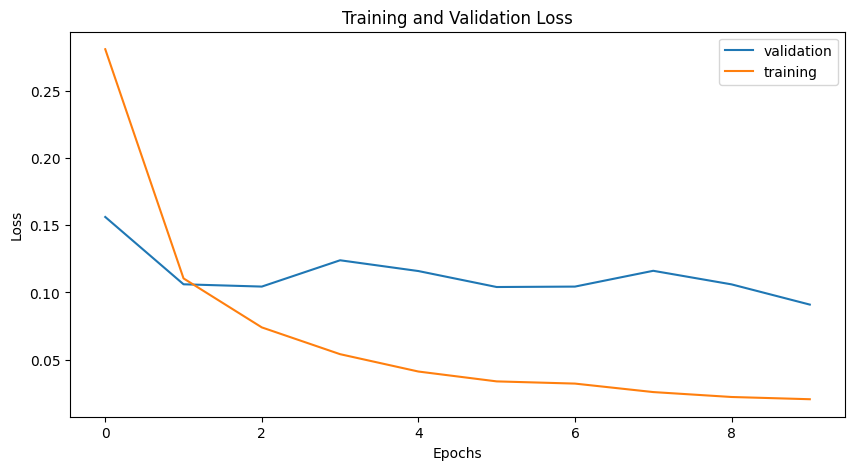

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 4 (Increasing width of layer):
* Optimizer Function: Adam
* Epochs: 10
* Width of each Layer: 512
* Depth of network: 4
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 95.8%, avg loss: 0.140744 

Epoch 2
-------------------------------
test loss: 
Accuracy: 96.5%, avg loss: 0.114478 

Epoch 3
-------------------------------
test loss: 
Accuracy: 97.1%, avg loss: 0.104481 

Epoch 4
-------------------------------
test loss: 
Accuracy: 96.4%, avg loss: 0.149731 

Epoch 5
-------------------------------
test loss: 
Accuracy: 96.4%, avg loss: 0.144749 

Epoch 6
-------------------------------
test loss: 
Accuracy: 98.1%, avg loss: 0.086261 

Epoch 7
-------------------------------
test loss: 
Accuracy: 97.9%, avg loss: 0.097346 

Epoch 8
-------------------------------
test loss: 
Accuracy: 97.4%, avg loss: 0.115617 

Epoch 9
-------------------------------
test loss: 
Accuracy: 97.5%, avg loss: 0.123411 

Epoch 10
-------------------------------
test loss: 
Accuracy: 98.1%, avg loss: 0.093738 

Done!


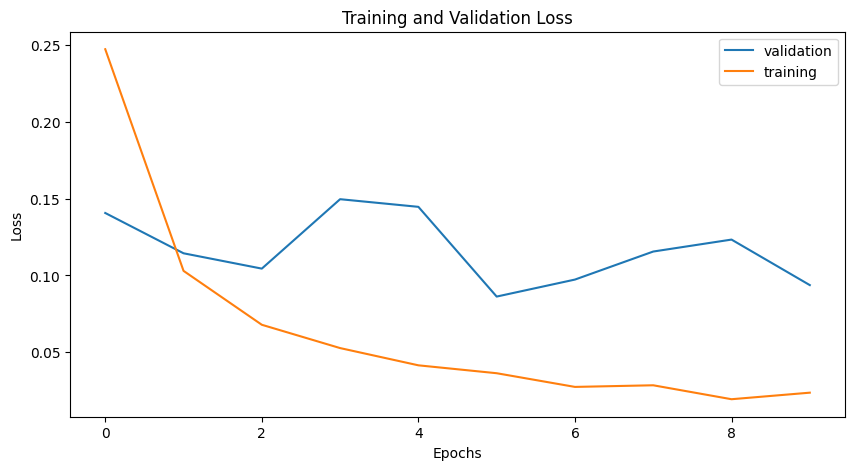

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 5 (Decreasing depth):
* Optimizer Function: Adam
* Epochs: 10
* Width of each Layer: 512
* Depth of network: 2
* Learning rate: 1e-4

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 95.9%, avg loss: 0.136817 

Epoch 2
-------------------------------
test loss: 
Accuracy: 96.7%, avg loss: 0.102665 

Epoch 3
-------------------------------
test loss: 
Accuracy: 96.8%, avg loss: 0.097181 

Epoch 4
-------------------------------
test loss: 
Accuracy: 96.9%, avg loss: 0.097829 

Epoch 5
-------------------------------
test loss: 
Accuracy: 97.3%, avg loss: 0.088591 

Epoch 6
-------------------------------
test loss: 
Accuracy: 96.8%, avg loss: 0.111510 

Epoch 7
-------------------------------
test loss: 
Accuracy: 97.7%, avg loss: 0.082234 

Epoch 8
-------------------------------
test loss: 
Accuracy: 97.9%, avg loss: 0.086080 

Epoch 9
-------------------------------
test loss: 
Accuracy: 97.8%, avg loss: 0.087735 

Epoch 10
-------------------------------
test loss: 
Accuracy: 98.0%, avg loss: 0.083743 

Done!


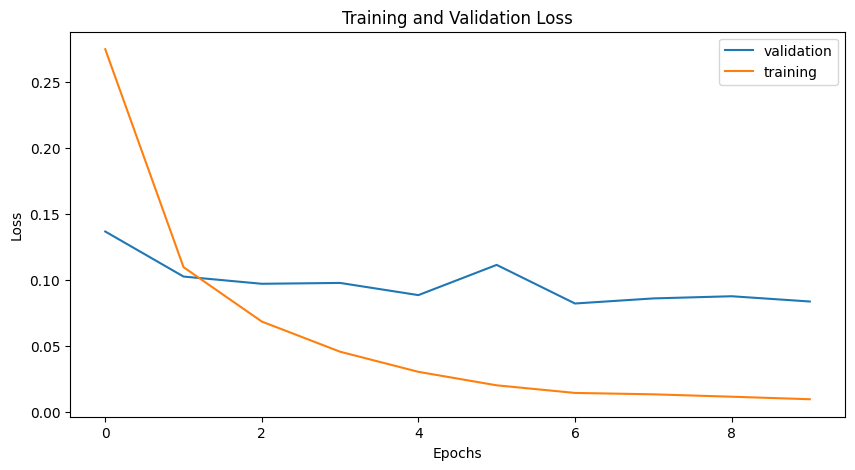

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 6 (Increasing depth):
* Optimizer Function: Adam
* Epochs: 10
* Width of each Layer: 256
* Depth of network: 5
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 94.6%, avg loss: 0.191308 

Epoch 2
-------------------------------
test loss: 
Accuracy: 96.2%, avg loss: 0.130986 

Epoch 3
-------------------------------
test loss: 
Accuracy: 96.2%, avg loss: 0.139851 

Epoch 4
-------------------------------
test loss: 
Accuracy: 96.9%, avg loss: 0.118543 

Epoch 5
-------------------------------
test loss: 
Accuracy: 97.2%, avg loss: 0.115336 

Epoch 6
-------------------------------
test loss: 
Accuracy: 97.4%, avg loss: 0.108778 

Epoch 7
-------------------------------
test loss: 
Accuracy: 97.1%, avg loss: 0.125842 

Epoch 8
-------------------------------
test loss: 
Accuracy: 97.5%, avg loss: 0.109283 

Epoch 9
-------------------------------
test loss: 
Accuracy: 97.7%, avg loss: 0.118731 

Epoch 10
-------------------------------
test loss: 
Accuracy: 97.8%, avg loss: 0.103722 

Done!


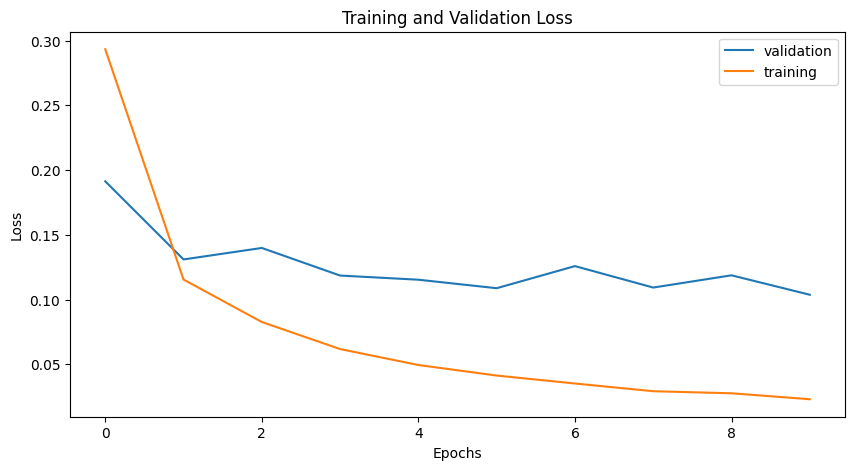

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 7 (Changing Learning rate):
* Optimizer Function: Adam
* Epochs: 50
* Width of each Layer: 256
* Depth of network: 4
* Learning rate: 1e-4

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 91.2%, avg loss: 0.299786 

Epoch 2
-------------------------------
test loss: 
Accuracy: 93.0%, avg loss: 0.230620 

Epoch 3
-------------------------------
test loss: 
Accuracy: 94.3%, avg loss: 0.188498 

Epoch 4
-------------------------------
test loss: 
Accuracy: 95.2%, avg loss: 0.159750 

Epoch 5
-------------------------------
test loss: 
Accuracy: 95.8%, avg loss: 0.138800 

Epoch 6
-------------------------------
test loss: 
Accuracy: 96.3%, avg loss: 0.123543 

Epoch 7
-------------------------------
test loss: 
Accuracy: 96.6%, avg loss: 0.112194 

Epoch 8
-------------------------------
test loss: 
Accuracy: 96.8%, avg loss: 0.104554 

Epoch 9
-------------------------------
test loss: 
Accuracy: 97.0%, avg loss: 0.098521 

Epoch 10
-------------------------------
test loss: 
Accuracy: 97.2%, avg loss: 0.094229 

Epoch 11
-------------------------------
test loss: 
Accuracy: 97.3%, avg loss: 0.090864 

Epoch 12

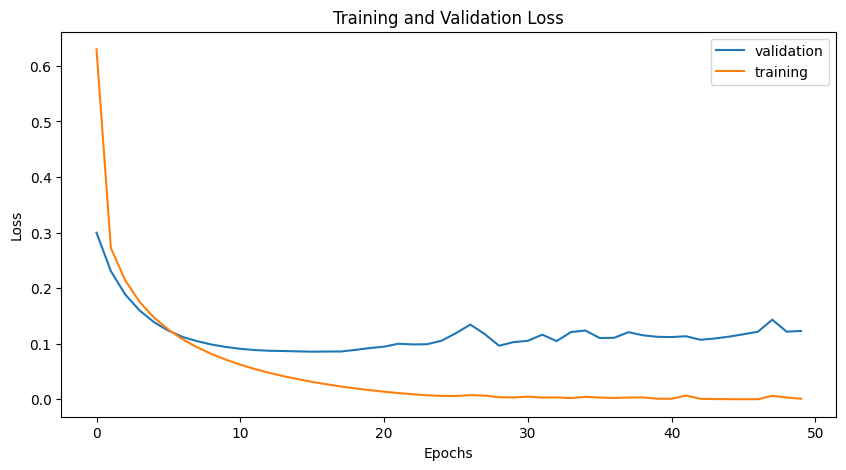

In [ ]:
epochs = 50
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 8 (Decreasing epochs with learning rate 1e-4):
* Optimizer Function: Adam
* Epochs: 20
* Width of each Layer: 512
* Depth of network: 4
* Learning rate: 1e-4

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 92.7%, avg loss: 0.244841 

Epoch 2
-------------------------------
test loss: 
Accuracy: 94.9%, avg loss: 0.167652 

Epoch 3
-------------------------------
test loss: 
Accuracy: 96.0%, avg loss: 0.131807 

Epoch 4
-------------------------------
test loss: 
Accuracy: 96.4%, avg loss: 0.114445 

Epoch 5
-------------------------------
test loss: 
Accuracy: 96.5%, avg loss: 0.106826 

Epoch 6
-------------------------------
test loss: 
Accuracy: 96.7%, avg loss: 0.103899 

Epoch 7
-------------------------------
test loss: 
Accuracy: 96.9%, avg loss: 0.098488 

Epoch 8
-------------------------------
test loss: 
Accuracy: 97.1%, avg loss: 0.095390 

Epoch 9
-------------------------------
test loss: 
Accuracy: 97.2%, avg loss: 0.094318 

Epoch 10
-------------------------------
test loss: 
Accuracy: 97.2%, avg loss: 0.098319 

Epoch 11
-------------------------------
test loss: 
Accuracy: 97.3%, avg loss: 0.094906 

Epoch 12

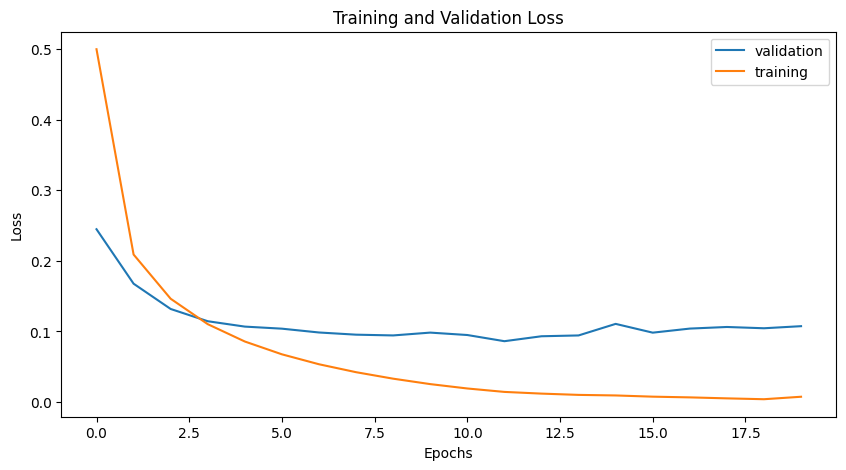

In [ ]:
epochs = 20
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 9 (Increasing epochs with le-3):
* Optimizer Function: Adam
* Epochs: 30
* Width of each Layer: 512
* Depth of network: 4
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 95.4%, avg loss: 0.158055 

Epoch 2
-------------------------------
test loss: 
Accuracy: 95.8%, avg loss: 0.141541 

Epoch 3
-------------------------------
test loss: 
Accuracy: 96.0%, avg loss: 0.151109 

Epoch 4
-------------------------------
test loss: 
Accuracy: 97.2%, avg loss: 0.107994 

Epoch 5
-------------------------------
test loss: 
Accuracy: 97.4%, avg loss: 0.108120 

Epoch 6
-------------------------------
test loss: 
Accuracy: 96.7%, avg loss: 0.144048 

Epoch 7
-------------------------------
test loss: 
Accuracy: 98.0%, avg loss: 0.086194 

Epoch 8
-------------------------------
test loss: 
Accuracy: 98.1%, avg loss: 0.084605 

Epoch 9
-------------------------------
test loss: 
Accuracy: 97.4%, avg loss: 0.134547 

Epoch 10
-------------------------------
test loss: 
Accuracy: 97.8%, avg loss: 0.103803 

Epoch 11
-------------------------------
test loss: 
Accuracy: 97.8%, avg loss: 0.096584 

Epoch 12

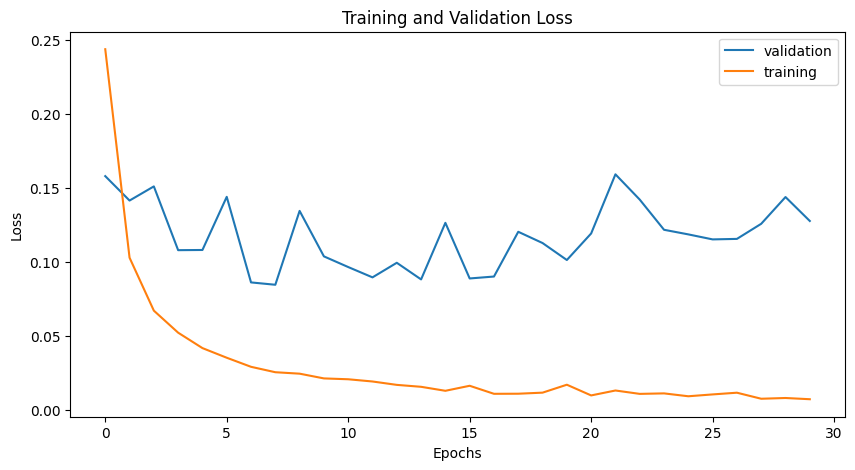

In [ ]:
epochs = 30
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 10 (Best Params):
* Optimizer Function: Adam
* Epochs: 50
* Width of each Layer: 512
* Depth of network: 4
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 95.3%, avg loss: 0.154229 

Epoch 2
-------------------------------
test loss: 
Accuracy: 97.0%, avg loss: 0.098713 

Epoch 3
-------------------------------
test loss: 
Accuracy: 97.0%, avg loss: 0.114765 

Epoch 4
-------------------------------
test loss: 
Accuracy: 97.1%, avg loss: 0.114761 

Epoch 5
-------------------------------
test loss: 
Accuracy: 97.2%, avg loss: 0.120653 

Epoch 6
-------------------------------
test loss: 
Accuracy: 97.8%, avg loss: 0.095894 

Epoch 7
-------------------------------
test loss: 
Accuracy: 97.7%, avg loss: 0.089743 

Epoch 8
-------------------------------
test loss: 
Accuracy: 97.9%, avg loss: 0.102671 

Epoch 9
-------------------------------
test loss: 
Accuracy: 98.3%, avg loss: 0.090006 

Epoch 10
-------------------------------
test loss: 
Accuracy: 97.9%, avg loss: 0.106140 

Epoch 11
-------------------------------
test loss: 
Accuracy: 97.5%, avg loss: 0.128583 

Epoch 12

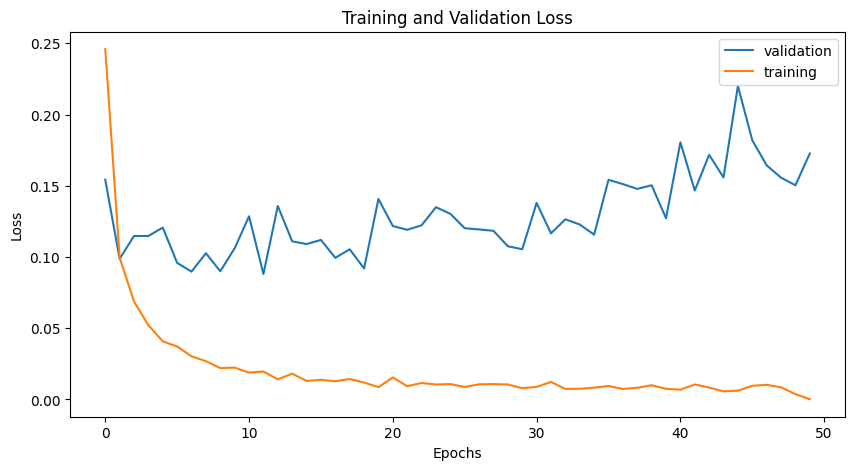

In [ ]:
epochs = 50
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Saving the best model

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Perform Inferrence

Predicted: "six", Actual: "four"


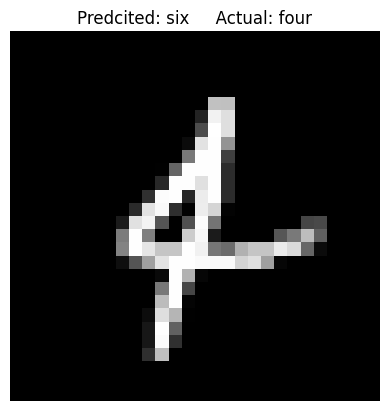

In [ ]:
classes = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
]
#classes = np.array(test_data.class_to_idx.values())
#testimg = random.
model.eval()
sample_number = 300 # Keep 0 <= sample_number < 10,000
x, y = test_data[sample_number][0], test_data[sample_number][1]
model.to("cpu")
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

img, label = test_data[sample_number]                            # Read the images using their indices.
    #figure.add_subplot(rows, cols, i)
plt.figure()
plt.title("Predcited: "+ predicted + "     Actual: " + labels_map[label])
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")

# Fashion MNIST Dataset

Loading the test and training dataset

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11849500.30it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 174030.78it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3269914.79it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5994524.43it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Visulalizing dataset

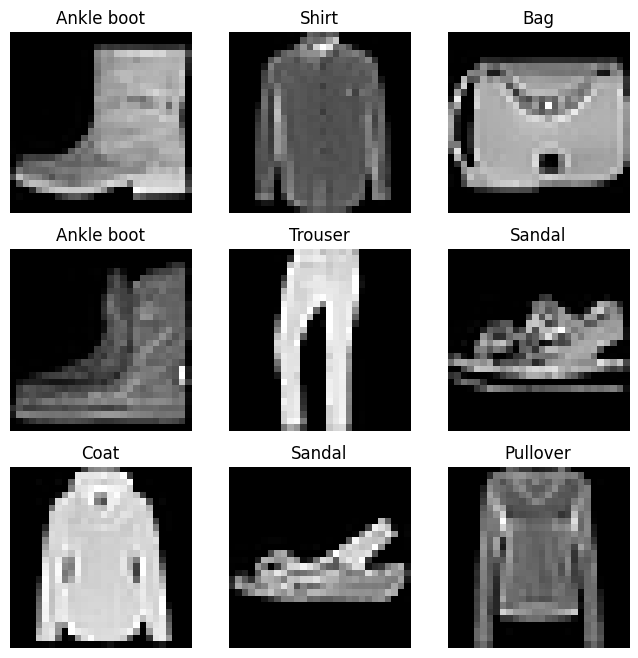

In [ ]:
# Define labels for Fashion MNIST classes
labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

# Create a figure for plotting
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Loop through and display random images
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()  # randomly pick indices from the training data
    img, label = training_data[sample_idx]                            # Read the images using their indices.
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

# Show the plot
plt.show()


Check the size of training data

In [ ]:
print("Shape of training dataset",np.shape(training_data))
print("Shape of test dataset",np.shape(test_data))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Shape of training dataset (60000, 2)
Shape of test dataset (10000, 2)


Creating data loader

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 25.1%, avg loss: 2.219220 

Epoch 2
-------------------------------
test loss: 
Accuracy: 40.6%, avg loss: 2.059418 

Epoch 3
-------------------------------
test loss: 
Accuracy: 54.4%, avg loss: 1.745476 

Epoch 4
-------------------------------
test loss: 
Accuracy: 58.9%, avg loss: 1.408930 

Epoch 5
-------------------------------
test loss: 
Accuracy: 62.4%, avg loss: 1.190583 

Done!


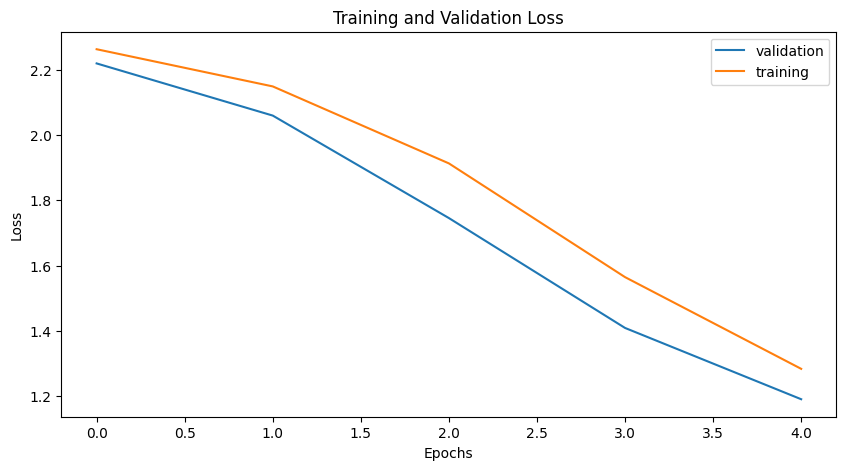

In [ ]:
epochs = 5
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Perform Inferrence

Predicted: "Dress", Actual: "Dress"


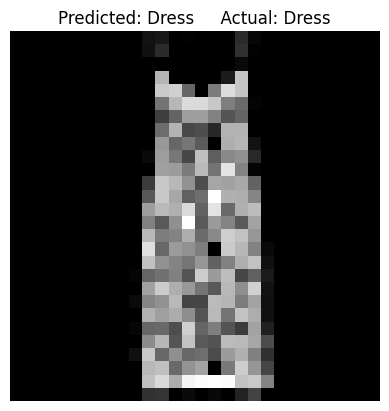

In [ ]:
# Define class labels for Fashion MNIST
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
sample_number = 300  # Choose a sample number (0 <= sample_number < len(test_data))
x, y = test_data[sample_number][0], test_data[sample_number][1]
model.to("cpu")

with torch.no_grad():
    pred = model(x.unsqueeze(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

img, label = test_data[sample_number]

# Display the image with predicted and actual labels
plt.figure()
plt.title("Predicted: " + predicted + "     Actual: " + actual)
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()


###Combination 1 (Increasing Epochs to 10):
* Optimizer Function: SGD
* Epochs: 10
* Width of each Layer: 128
* Depth of network: 3
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 29.9%, avg loss: 2.204159 

Epoch 2
-------------------------------
test loss: 
Accuracy: 39.2%, avg loss: 2.020152 

Epoch 3
-------------------------------
test loss: 
Accuracy: 50.2%, avg loss: 1.700045 

Epoch 4
-------------------------------
test loss: 
Accuracy: 58.0%, avg loss: 1.407194 

Epoch 5
-------------------------------
test loss: 
Accuracy: 61.9%, avg loss: 1.218628 

Epoch 6
-------------------------------
test loss: 
Accuracy: 63.4%, avg loss: 1.089342 

Epoch 7
-------------------------------
test loss: 
Accuracy: 64.8%, avg loss: 0.997272 

Epoch 8
-------------------------------
test loss: 
Accuracy: 65.8%, avg loss: 0.931071 

Epoch 9
-------------------------------
test loss: 
Accuracy: 67.0%, avg loss: 0.881537 

Epoch 10
-------------------------------
test loss: 
Accuracy: 68.1%, avg loss: 0.843530 

Done!


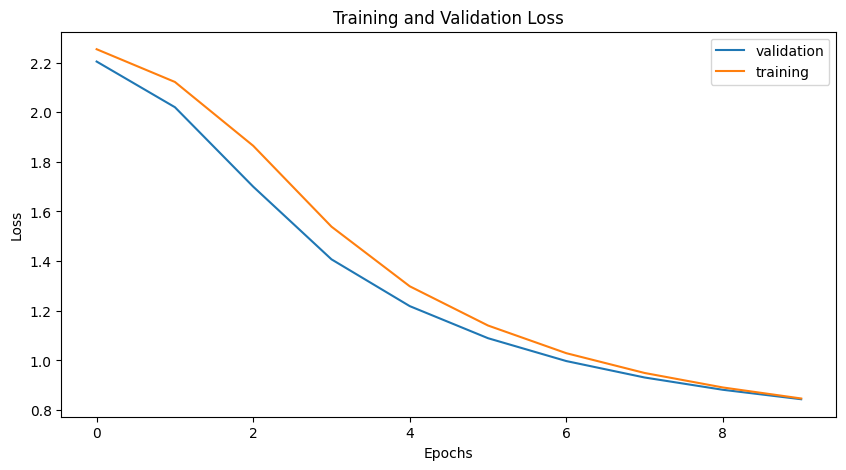

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 2 (Increasing Epochs to 50 and changing optimizer to Adam):
* Optimizer Function: Adam
* Epochs: 50
* Width of each Layer: 128
* Depth of network: 3
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 83.1%, avg loss: 0.466691 

Epoch 2
-------------------------------
test loss: 
Accuracy: 84.7%, avg loss: 0.427984 

Epoch 3
-------------------------------
test loss: 
Accuracy: 85.9%, avg loss: 0.394731 

Epoch 4
-------------------------------
test loss: 
Accuracy: 86.7%, avg loss: 0.370199 

Epoch 5
-------------------------------
test loss: 
Accuracy: 87.1%, avg loss: 0.358909 

Epoch 6
-------------------------------
test loss: 
Accuracy: 87.4%, avg loss: 0.346443 

Epoch 7
-------------------------------
test loss: 
Accuracy: 87.8%, avg loss: 0.345641 

Epoch 8
-------------------------------
test loss: 
Accuracy: 87.7%, avg loss: 0.345905 

Epoch 9
-------------------------------
test loss: 
Accuracy: 87.5%, avg loss: 0.352730 

Epoch 10
-------------------------------
test loss: 
Accuracy: 87.6%, avg loss: 0.353539 

Epoch 11
-------------------------------
test loss: 
Accuracy: 88.2%, avg loss: 0.352611 

Epoch 12

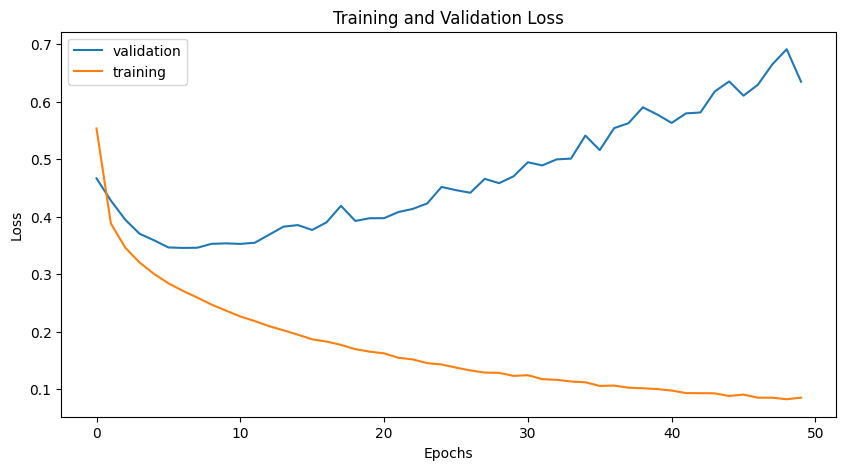

In [ ]:
epochs = 50
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 3 (Changing depth):
* Optimizer Function: Adam
* Epochs: 10
* Width of each Layer: 128
* Depth of network: 4
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 83.4%, avg loss: 0.462010 

Epoch 2
-------------------------------
test loss: 
Accuracy: 84.5%, avg loss: 0.420396 

Epoch 3
-------------------------------
test loss: 
Accuracy: 85.5%, avg loss: 0.394125 

Epoch 4
-------------------------------
test loss: 
Accuracy: 86.2%, avg loss: 0.382046 

Epoch 5
-------------------------------
test loss: 
Accuracy: 86.5%, avg loss: 0.366595 

Epoch 6
-------------------------------
test loss: 
Accuracy: 87.1%, avg loss: 0.347590 

Epoch 7
-------------------------------
test loss: 
Accuracy: 87.0%, avg loss: 0.355028 

Epoch 8
-------------------------------
test loss: 
Accuracy: 87.2%, avg loss: 0.359530 

Epoch 9
-------------------------------
test loss: 
Accuracy: 87.0%, avg loss: 0.378934 

Epoch 10
-------------------------------
test loss: 
Accuracy: 87.8%, avg loss: 0.344186 

Done!


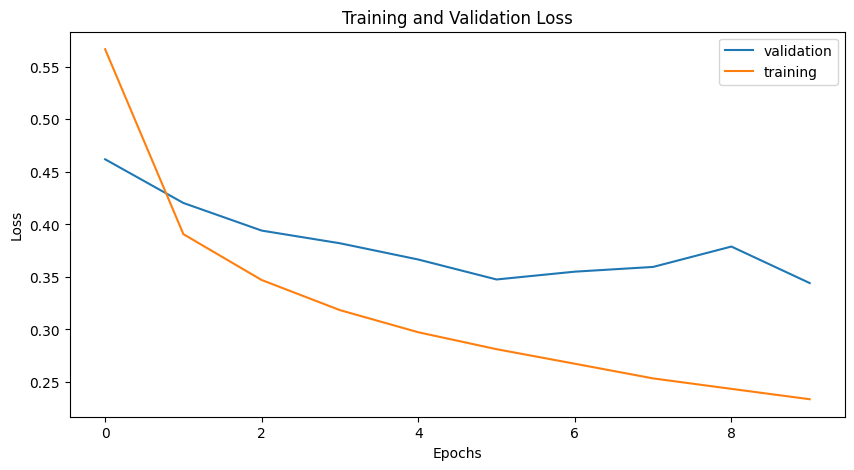

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 4 (Increasing width of layer to 256):
* Optimizer Function: Adam
* Epochs: 10
* Width of each Layer: 256
* Depth of network: 3
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 84.3%, avg loss: 0.435531 

Epoch 2
-------------------------------
test loss: 
Accuracy: 85.7%, avg loss: 0.392084 

Epoch 3
-------------------------------
test loss: 
Accuracy: 85.9%, avg loss: 0.383594 

Epoch 4
-------------------------------
test loss: 
Accuracy: 86.9%, avg loss: 0.364907 

Epoch 5
-------------------------------
test loss: 
Accuracy: 87.0%, avg loss: 0.355711 

Epoch 6
-------------------------------
test loss: 
Accuracy: 87.1%, avg loss: 0.355301 

Epoch 7
-------------------------------
test loss: 
Accuracy: 87.2%, avg loss: 0.354743 

Epoch 8
-------------------------------
test loss: 
Accuracy: 87.7%, avg loss: 0.357602 

Epoch 9
-------------------------------
test loss: 
Accuracy: 87.5%, avg loss: 0.361371 

Epoch 10
-------------------------------
test loss: 
Accuracy: 87.7%, avg loss: 0.359950 

Done!


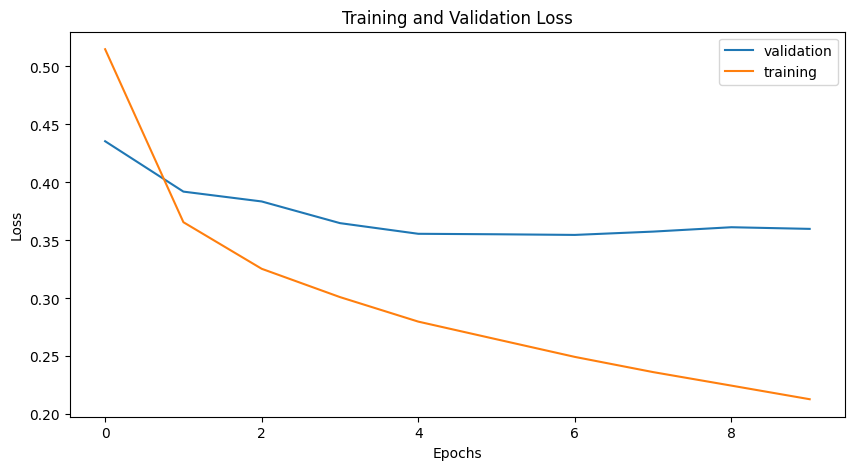

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 5 (Increasing width to 512):
* Optimizer Function: Adam
* Epochs: 10
* Width of each Layer: 512
* Depth of network: 3
* Learning rate: 1e-4

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 84.8%, avg loss: 0.423116 

Epoch 2
-------------------------------
test loss: 
Accuracy: 85.5%, avg loss: 0.387989 

Epoch 3
-------------------------------
test loss: 
Accuracy: 86.2%, avg loss: 0.371835 

Epoch 4
-------------------------------
test loss: 
Accuracy: 86.5%, avg loss: 0.375893 

Epoch 5
-------------------------------
test loss: 
Accuracy: 87.1%, avg loss: 0.353039 

Epoch 6
-------------------------------
test loss: 
Accuracy: 87.0%, avg loss: 0.362176 

Epoch 7
-------------------------------
test loss: 
Accuracy: 87.7%, avg loss: 0.355635 

Epoch 8
-------------------------------
test loss: 
Accuracy: 88.4%, avg loss: 0.341502 

Epoch 9
-------------------------------
test loss: 
Accuracy: 88.1%, avg loss: 0.354623 

Epoch 10
-------------------------------
test loss: 
Accuracy: 87.4%, avg loss: 0.371002 

Done!


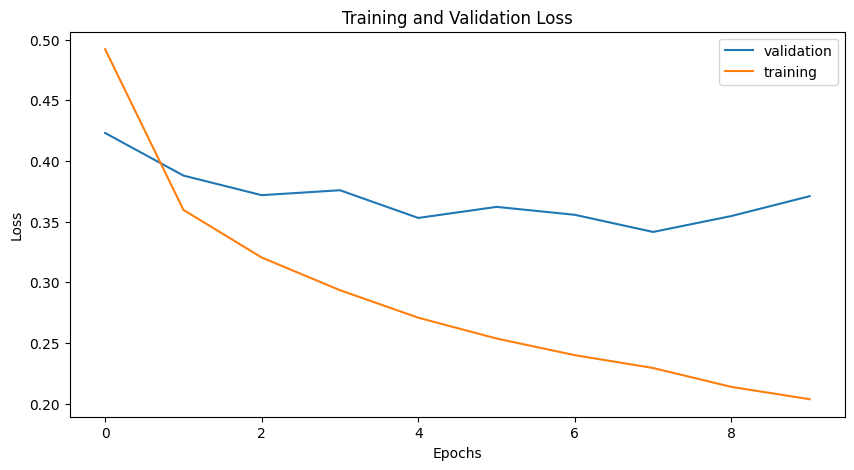

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 6 (Decreasing depth):
* Optimizer Function: Adam
* Epochs: 10
* Width of each Layer: 512
* Depth of network: 2
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 85.1%, avg loss: 0.420140 

Epoch 2
-------------------------------
test loss: 
Accuracy: 85.5%, avg loss: 0.399279 

Epoch 3
-------------------------------
test loss: 
Accuracy: 86.5%, avg loss: 0.370790 

Epoch 4
-------------------------------
test loss: 
Accuracy: 86.7%, avg loss: 0.366605 

Epoch 5
-------------------------------
test loss: 
Accuracy: 87.1%, avg loss: 0.363289 

Epoch 6
-------------------------------
test loss: 
Accuracy: 87.5%, avg loss: 0.349060 

Epoch 7
-------------------------------
test loss: 
Accuracy: 87.4%, avg loss: 0.356143 

Epoch 8
-------------------------------
test loss: 
Accuracy: 87.5%, avg loss: 0.357503 

Epoch 9
-------------------------------
test loss: 
Accuracy: 87.6%, avg loss: 0.372275 

Epoch 10
-------------------------------
test loss: 
Accuracy: 87.9%, avg loss: 0.348740 

Done!


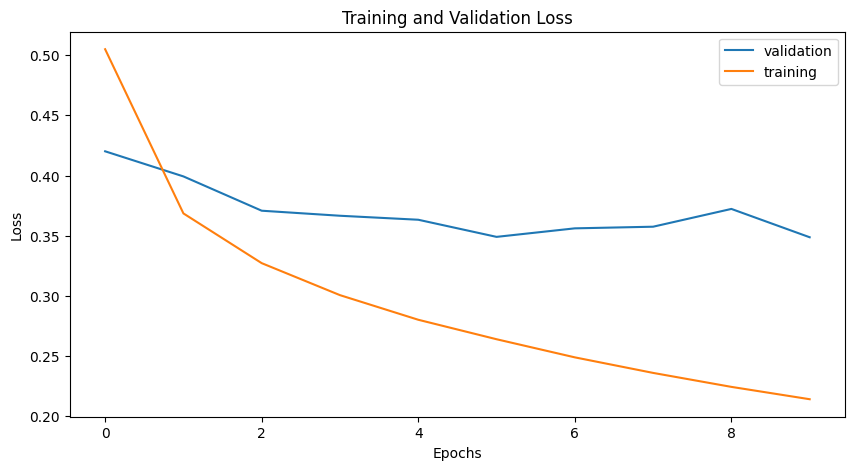

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 7 (Changing Learning rate):
* Optimizer Function: Adam
* Epochs: 10
* Width of each Layer: 512
* Depth of network: 3
* Learning rate: 1e-4

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 82.2%, avg loss: 0.493597 

Epoch 2
-------------------------------
test loss: 
Accuracy: 84.5%, avg loss: 0.436796 

Epoch 3
-------------------------------
test loss: 
Accuracy: 85.5%, avg loss: 0.410120 

Epoch 4
-------------------------------
test loss: 
Accuracy: 86.0%, avg loss: 0.392611 

Epoch 5
-------------------------------
test loss: 
Accuracy: 86.4%, avg loss: 0.379755 

Epoch 6
-------------------------------
test loss: 
Accuracy: 86.6%, avg loss: 0.369933 

Epoch 7
-------------------------------
test loss: 
Accuracy: 86.8%, avg loss: 0.360971 

Epoch 8
-------------------------------
test loss: 
Accuracy: 87.1%, avg loss: 0.354769 

Epoch 9
-------------------------------
test loss: 
Accuracy: 87.3%, avg loss: 0.349989 

Epoch 10
-------------------------------
test loss: 
Accuracy: 87.5%, avg loss: 0.345435 

Done!


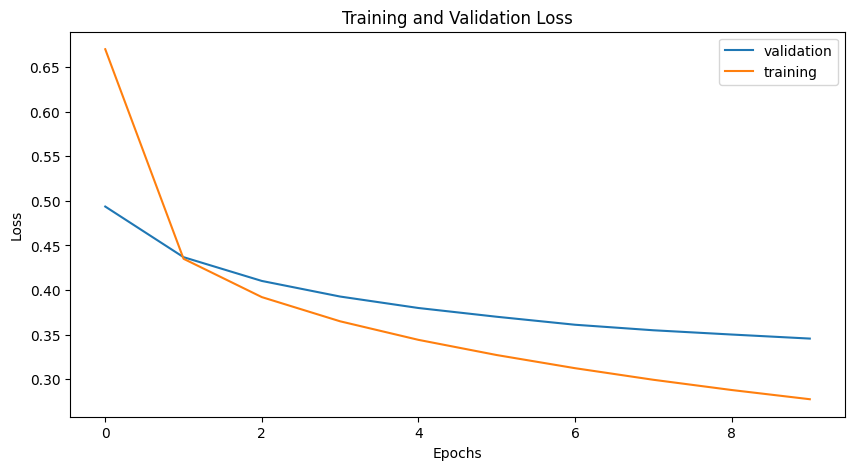

In [ ]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 8 (Increasing epochs with learning rate 1e-4):
* Optimizer Function: Adam
* Epochs: 20
* Width of each Layer: 512
* Depth of network: 3
* Learning rate: 1e-4

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 82.2%, avg loss: 0.494698 

Epoch 2
-------------------------------
test loss: 
Accuracy: 84.6%, avg loss: 0.438868 

Epoch 3
-------------------------------
test loss: 
Accuracy: 85.4%, avg loss: 0.411422 

Epoch 4
-------------------------------
test loss: 
Accuracy: 86.0%, avg loss: 0.392379 

Epoch 5
-------------------------------
test loss: 
Accuracy: 86.4%, avg loss: 0.377904 

Epoch 6
-------------------------------
test loss: 
Accuracy: 86.8%, avg loss: 0.367097 

Epoch 7
-------------------------------
test loss: 
Accuracy: 87.2%, avg loss: 0.358170 

Epoch 8
-------------------------------
test loss: 
Accuracy: 87.4%, avg loss: 0.351020 

Epoch 9
-------------------------------
test loss: 
Accuracy: 87.5%, avg loss: 0.345170 

Epoch 10
-------------------------------
test loss: 
Accuracy: 87.7%, avg loss: 0.341041 

Epoch 11
-------------------------------
test loss: 
Accuracy: 87.9%, avg loss: 0.337125 

Epoch 12

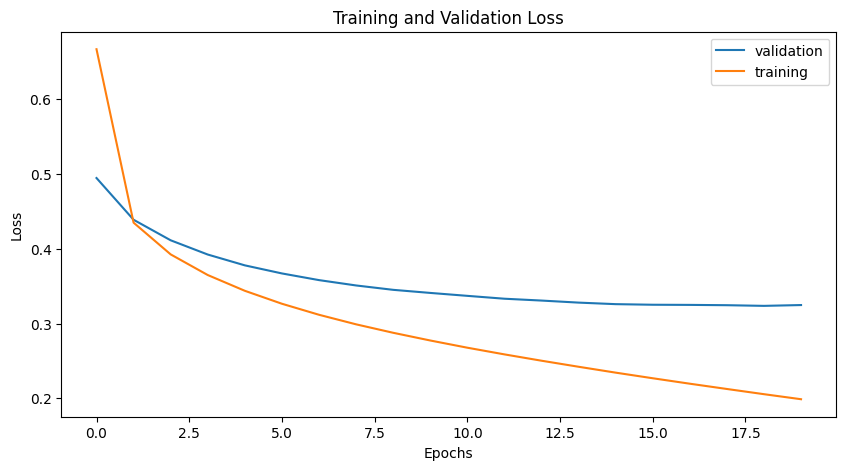

In [ ]:
epochs = 20
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 9 (Increasing epochs with le-3):
* Optimizer Function: Adam
* Epochs: 20
* Width of each Layer: 512
* Depth of network: 3
* Learning rate: 1e-3

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 84.7%, avg loss: 0.425624 

Epoch 2
-------------------------------
test loss: 
Accuracy: 85.4%, avg loss: 0.396138 

Epoch 3
-------------------------------
test loss: 
Accuracy: 86.0%, avg loss: 0.378523 

Epoch 4
-------------------------------
test loss: 
Accuracy: 86.4%, avg loss: 0.373861 

Epoch 5
-------------------------------
test loss: 
Accuracy: 87.2%, avg loss: 0.353471 

Epoch 6
-------------------------------
test loss: 
Accuracy: 87.4%, avg loss: 0.358073 

Epoch 7
-------------------------------
test loss: 
Accuracy: 87.5%, avg loss: 0.351928 

Epoch 8
-------------------------------
test loss: 
Accuracy: 88.0%, avg loss: 0.347730 

Epoch 9
-------------------------------
test loss: 
Accuracy: 88.2%, avg loss: 0.364561 

Epoch 10
-------------------------------
test loss: 
Accuracy: 87.2%, avg loss: 0.412223 

Epoch 11
-------------------------------
test loss: 
Accuracy: 88.2%, avg loss: 0.375798 

Epoch 12

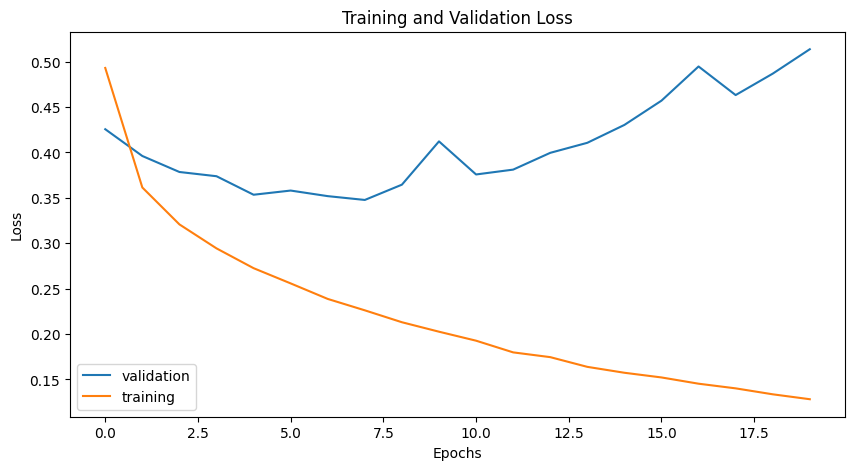

In [ ]:
epochs = 20
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Combination 10 (Increased Epochs):
* Optimizer Function: Adam
* Epochs: 50
* Width of each Layer: 512
* Depth of network: 3
* Learning rate: 1e-4

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 82.5%, avg loss: 0.489423 

Epoch 2
-------------------------------
test loss: 
Accuracy: 84.7%, avg loss: 0.434262 

Epoch 3
-------------------------------
test loss: 
Accuracy: 85.7%, avg loss: 0.406790 

Epoch 4
-------------------------------
test loss: 
Accuracy: 86.2%, avg loss: 0.388729 

Epoch 5
-------------------------------
test loss: 
Accuracy: 86.6%, avg loss: 0.374803 

Epoch 6
-------------------------------
test loss: 
Accuracy: 86.9%, avg loss: 0.365095 

Epoch 7
-------------------------------
test loss: 
Accuracy: 87.1%, avg loss: 0.356710 

Epoch 8
-------------------------------
test loss: 
Accuracy: 87.4%, avg loss: 0.350734 

Epoch 9
-------------------------------
test loss: 
Accuracy: 87.7%, avg loss: 0.344636 

Epoch 10
-------------------------------
test loss: 
Accuracy: 87.8%, avg loss: 0.340066 

Epoch 11
-------------------------------
test loss: 
Accuracy: 88.0%, avg loss: 0.336930 

Epoch 12

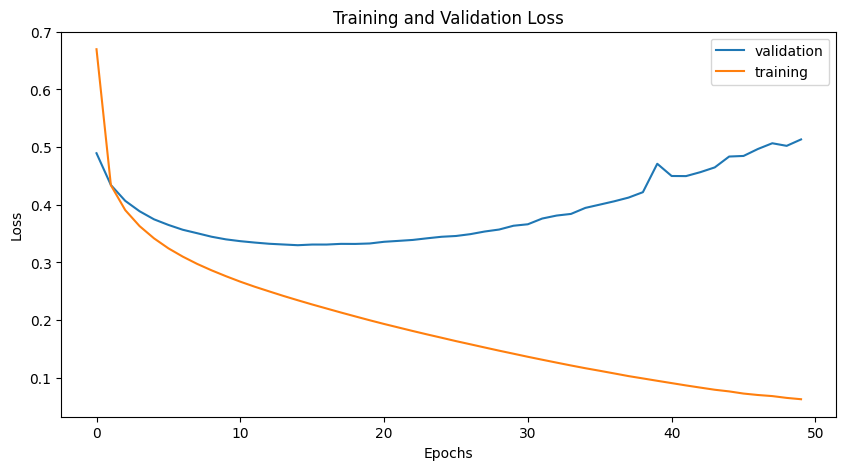

In [ ]:
epochs = 50
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

###Best Parameters with final accuracy of 88.8%:
* Optimizer Function: Adam
* Epochs: 20
* Width of each Layer: 512
* Depth of network: 3
* Learning rate: 1e-4

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 )

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()                   # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Epoch 1
-------------------------------
test loss: 
Accuracy: 82.2%, avg loss: 0.494698 

Epoch 2
-------------------------------
test loss: 
Accuracy: 84.6%, avg loss: 0.438868 

Epoch 3
-------------------------------
test loss: 
Accuracy: 85.4%, avg loss: 0.411422 

Epoch 4
-------------------------------
test loss: 
Accuracy: 86.0%, avg loss: 0.392379 

Epoch 5
-------------------------------
test loss: 
Accuracy: 86.4%, avg loss: 0.377904 

Epoch 6
-------------------------------
test loss: 
Accuracy: 86.8%, avg loss: 0.367097 

Epoch 7
-------------------------------
test loss: 
Accuracy: 87.2%, avg loss: 0.358170 

Epoch 8
-------------------------------
test loss: 
Accuracy: 87.4%, avg loss: 0.351020 

Epoch 9
-------------------------------
test loss: 
Accuracy: 87.5%, avg loss: 0.345170 

Epoch 10
-------------------------------
test loss: 
Accuracy: 87.7%, avg loss: 0.341041 

Epoch 11
-------------------------------
test loss: 
Accuracy: 87.9%, avg loss: 0.337125 

Epoch 12

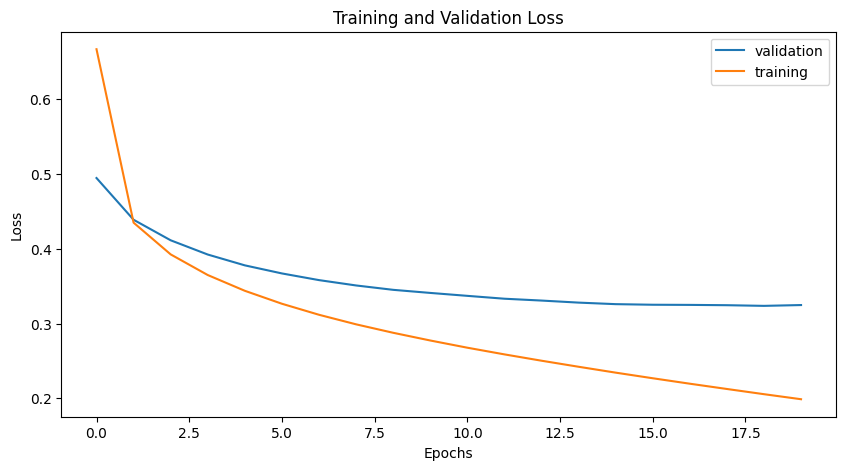

In [ ]:
epochs = 20
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()